In [3]:
import pandas as pd
import plotly.express as px

In [4]:
import numpy as np

In [5]:
from datetime import datetime


In [8]:
parking_data=pd.read_csv("C:\\Users\\desai\\Downloads\\merged_parking.csv")

In [9]:
parking_data["lat_1"]=parking_data["coord_1"].apply(lambda x:x.strip('[').strip(']').split(',')[0])

In [10]:
parking_data["long_1"]=parking_data["coord_1"].apply(lambda x:x.strip('[').strip(']').split(',')[1])

In [11]:
parking_data["lat_2"]=parking_data["coord_2"].apply(lambda x:x.strip('[').strip(']').split(',')[0])

In [12]:
parking_data["long_2"]=parking_data["coord_2"].apply(lambda x:x.strip('[').strip(']').split(',')[1])

In [13]:
geo_cols=[col for col in parking_data.columns if "lat" in col or "long" in col]

In [19]:
for col in geo_cols:
  parking_data[col]=parking_data[col].astype(float)

In [20]:
agg_dataset_status=parking_data.groupby(by='Status').count()

In [22]:
fig = px.bar(x=agg_dataset_status.index,y=agg_dataset_status.iloc[:,0],text=agg_dataset_status.iloc[:,0],title='Count of Infractions by Status')
fig.show()

In [23]:
parking_data["EntryDate"]=parking_data["EntryDate"].apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))

In [24]:
parking_data["EntryDate"]

0       2017-08-23
1       2018-07-25
2       2019-07-03
3       2018-01-08
4       2018-01-04
           ...    
35472   2019-12-12
35473   2019-12-12
35474   2019-12-12
35475   2019-12-12
35476   2019-12-12
Name: EntryDate, Length: 35477, dtype: datetime64[ns]

In [25]:
parking_data["Month"]=parking_data["EntryDate"].apply(lambda x:x.month)

In [26]:
parking_data["EntryDate"].dt.to_period('M').iloc[0]

Period('2017-08', 'M')

In [28]:
agg_data_month_every_year=parking_data.groupby(by=parking_data["EntryDate"].dt.to_period('M')).count()

In [29]:
fig = px.line(x=agg_data_month_every_year.index.astype('datetime64[ns]'),
              y=agg_data_month_every_year.iloc[:,0],title='Count of Infractions by Month each year')                  #,range_x=['2017-01-01','2019-12-1'])
fig.update_xaxes(rangeslider_visible=True)
fig.show()

The top anomaly detected on Oct 8, 2019 was:

Total count of Infractionts is 487, which was higher than the expected 105

In [30]:
agg_date_street_use=parking_data.groupby(by='STREETUSE').count()

In [32]:
fig = px.bar(x=agg_date_street_use.index,
             y=agg_date_street_use.iloc[:,0],title='Count of Infractions by Street Use',
             text=agg_date_street_use.iloc[:,0])
fig.show()

In [4]:
selected_variables = ["Street", "coord_1", "coord_2", "STREETUSE", "Status"]
df = parking_data[selected_variables].copy()
df.head()

,Street,coord_1,coord_2,STREETUSE,Status
0,Kingsway,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]",Arterial,IS
1,KINGSWAY,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]",Arterial,IS
2,KINGSWAY,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]",Arterial,VA
3,KINGSWAY,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]",Arterial,IS
4,KINGSWAY,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]",Arterial,IS


Removing the observations with the RA status as there are only 7 in number !

In [5]:
df=df[df['Status']!='RA']

In [6]:
# Encoding of the categorical variables
# https://www.hackdeploy.com/python-one-hot-encoding-with-scikit-learn/
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

from sklearn.preprocessing import LabelEncoder
le_street = LabelEncoder()
le_streetuse = LabelEncoder()
le_entrydate = LabelEncoder()
le_coord_1 = LabelEncoder()
le_coord_2 = LabelEncoder()
le_status = LabelEncoder()

df['Street'] = le_street.fit_transform(df.Street)
df['STREETUSE'] = le_streetuse.fit_transform(df.STREETUSE)

df['coord_1'] = le_coord_1.fit_transform(df.coord_1)
df['coord_2'] = le_coord_2.fit_transform(df.coord_2)
df['Status'] = le_status.fit_transform(df.Status)

df.head()

,Street,coord_1,coord_2,STREETUSE,Status
0,246,903,888,0,0
1,238,903,888,0,0
2,238,903,888,0,1
3,238,903,888,0,0
4,238,903,888,0,0


In [7]:
#IS(CATEGORY 0) : 32428
#VA(CATEGORY 1) : 2367
#WR(CATEGORY 3) : 580
#VS(CATEGORY 2) : 95
df.Status.value_counts()


0    32428
1     2367
3      580
2       95
Name: Status, dtype: int64

In [8]:
from collections import Counter
Counter(df.Status.values)

Counter({0: 32428, 1: 2367, 2: 95, 3: 580})

In [17]:
# Separate into variables and target variable
X=df.iloc[:,0:3].values
y=df.iloc[:,4].values

In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [19]:

over = SMOTE(sampling_strategy={0: 32428, 1: 30000, 2: 20000, 3:30000})
# transform the dataset
X, y = over.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


X_train, y_train = make_classification(n_samples=1000, n_features=3, n_informative=2, n_redundant=0, random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

 
*  Our model gives a weighted precision of about 0.80 considering all the classes which means the true positive rate or the  correctly identified occurences of  infractions of each class is 80%  

* The weighted recall of about 0.27 which means 27% of true positives correctly identified in a collection of true positives and false negatives

* The weighted f1-score is 0.11 which is simply the harmonic mean of the above two measures






In [44]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      8107
           1       0.27      1.00      0.42      7500
           2       1.00      0.00      0.00      5000
           3       1.00      0.00      0.00      7500

    accuracy                           0.27     28107
   macro avg       0.82      0.25      0.11     28107
weighted avg       0.80      0.27      0.11     28107



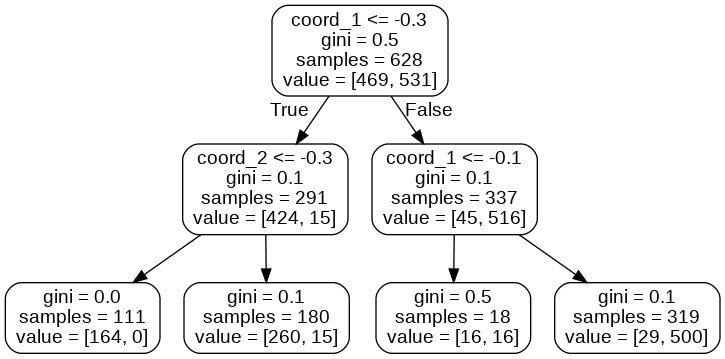

In [27]:
from google.colab.patches import cv2_imshow
import cv2  
img = cv2.imread("/content/tree.png") 
  

cv2_imshow(img) 
  

